<span style="font-size: 20px; color: white; background-color: #008ABC">(ignore this ⤴ warning about deleted datasets!)</span>

# An Analytical Approach to NO<sub>2</sub> Emissions
**TL;DR: I take an analytical approach, measuring a line density of NO2 on windy days at each point and fitting a distribution function to this line. This function gives the emissions in kg/hr. I use night time lights satellite imagery as a proxy for human activity to separate power and non-power emissions and then use the generation at each site with this value to calculate an emissions factor in kg/MWh.**

## Overview
We need to calculate the emissions factor in kg/MWh (or some equivalent) averaged for one year of Puerto Rico's energy production.
Bonus points if we can calculate sub-annual and marginal emissions factors.

So we need to figure out the following system:
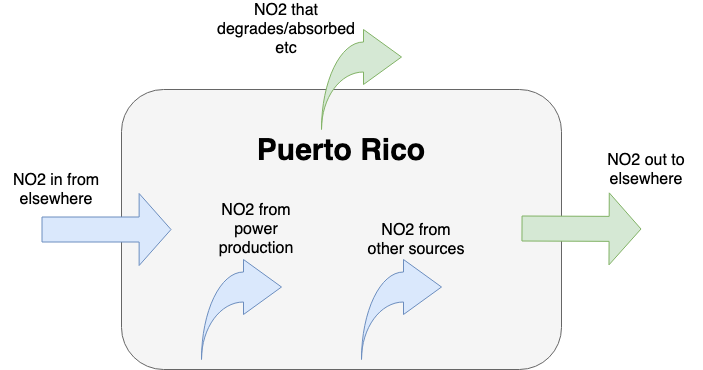

Puerto Rico's wind blows mainly from the east, so there won't be any pollution blown in. But the rest still need to be accounted for.

This problem definitely seems to want an analytical approach (rather than statistics/machine learning) so I'm going to go with that (and check if it makes sense along the way). In addition, I'm going to keep the data sources as simple as possible! There are several places where I could improve the accuracy by including more data from Google Earth Engine and other sources, but as this is a demonstration of a method, I'm going to keep it simple. For example, as I'm going to focus on the troposphere as a whole, I should probably use several wind fields that apply to the whole troposphere, instead of just the GFS data near the ground.

## Emissions factor
Simplifying from the [EPA formula](https://www.epa.gov/air-emissions-factors-and-quantification/basic-information-air-emissions-factors-and-quantification#About%20Emissions%20Factors):  
*EF = E / G*

where:
- EF: emissions factor (kg/MWh)
- E: emissions (kg/hr)
- G: generation (MWh/hr)

So if I can determine the *emissions* that are attributable to electricity generation, and if I know the *generation*, then I can calculate the emissions factor!

Quick explanation that may be useful: a plant's *capacity*, usually measured in MW (megawatts) is the maximum instantaneous power it can output, while it's *generation*, often in MWh (megawatt-hours) is the amount of energy actually produced in a given time period. If the plant runs at full capacity non-stop (i.e. capacity factor equals 100%) then the generation will be a simple multiple of capacity. Normally, however, plants produce much less, and have a capacity factor below 100%. It might be 30% for wind and solar, 50-60% for fossil fuels, and 80%+ for nuclear power.

In [ ]:
# Imports
from pathlib import Path
from pprint import pprint
import json
from datetime import datetime
from calendar import monthrange
from math import sqrt, pi, exp, sin, cos

import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import rasterio as rio
from rasterstats import zonal_stats
from affine import Affine
from tqdm.notebook import tqdm
import folium
import branca

sns.set() # For pretty charts

In [ ]:
# Paths
root = Path("/kaggle/input/")
admin_path = root / "world-geo-data" / "ne_10m_admin_1_states_provinces.shp"  # admin boundaries
viirs_path = root / "viirs-dnb-annual-puertorico" / "viirs-pr-2019.tif"  # night lights
eia_path = root / "eia923-pr-2018" / "EIA923_PR_2018.csv"  # plant generation data
eie = root / "ds4g-environmental-insights-explorer" / "eie_data"
s5p_path = eie / "s5p_no2"  # Sentinel 5P
gldas_path = eie / "gldas"  # Land Data
gfs_path = eie / "gfs"  # forecast
gppd_path = eie / "gppd" / "gppd_120_pr.csv"  # power plants

In [ ]:
# Load the administrative boundary
admin = gpd.read_file(admin_path)
admin = admin.loc[admin.name == "Puerto Rico"]

# Power System Overview
## Before going any further, let's look at the power system
This data comes from the WRI's [Global Power Plant Database](https://developers.google.com/earth-engine/datasets/catalog/WRI_GPPD_power_plants), which has relatively detailed data on most of the power plants in the world.

Fun fact: I contributed some of the GPPD data and sources for Bolivia!

In [ ]:
fossil_fuels = [
    "Oil",
    "Gas",
    "Coal"
]

In [ ]:
def show_gppd_summary(gppd):
    """
    Display a quick summary of power plants, broken down by fuel.
    """
    
    sns.set_style("whitegrid")
    tot_mw = gppd.capacity_mw.sum()
    fossil_mw = gppd.loc[(gppd.primary_fuel.isin(fossil_fuels))].capacity_mw.sum()
    print(f"{100*fossil_mw/tot_mw:.0f}% of total capacity is fossil fuel-based")

    fuel_tots = gppd.groupby('primary_fuel')['capacity_mw'].sum().sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(18,6))
    fuel_tots.plot.bar(
        ax=ax,
        color=['gray', 'darkblue', 'black', 'orange','green','blue']
    )
    ax.set_title("Total capacity by fuel", fontsize=16)
    ax.set_ylabel("Total capacity (MW)", fontsize=16)
    ax.set_xlabel("Fuel", fontsize=16)
    ax.set_xlabel("Fuel")
    ax.xaxis.grid(False)
    ax.set_ylim([0, 5000])
    ax.tick_params(axis='both', which='both', labelsize=12)
    sns.despine()
    plt.show()

In [ ]:
gppd = pd.read_csv(gppd_path)
show_gppd_summary(gppd)

## What does this tell us?
Average NO<sub>x</sub> emissions factor in the US is 0.36 kg/MWh ([source](https://www.eia.gov/electricity/state/unitedstates/index.php)). We should expect the value for Puerto Rico to be significantly higher, around 1 kg/MWh, as it relies much more on fossil fuels than the US as a whole.

Some rough emissions factors by fuel ([source](https://www3.epa.gov/ttnchie1/conference/ei19/session10/gpouliot.pdf))
- coal: 11 - 45 kg/MWh
- oil: 1.6 - 3.2 kg/MWh
- gas: 0.16 - 0.32 kg/MWh

As Puerto Rico mostly runs on oil, the emissions factor could be higher still.

For the majority of this investigation, I'm going to focus on these oil, gas and coal power plants, as these will be responsible for the bulk of pollution. I'll have to bring the others back in to get the total (and marginal!) emissions factors. For now, I'm going a step further, and only including the larger fossil fuel plants (above 150 MW), as these are the only ones likely to make a significant individual, measurable contribution to NO2 pollution. I'll assess these steps later to understand if I'm introducing any inaccuracies by simplifying like this!

That gives us the following plants:

In [ ]:
min_capacity = 150
print("Fossil-fuel plants above 150 MW capacity:")
print(", ".join(gppd.loc[(gppd.primary_fuel.isin(fossil_fuels)) & (gppd.capacity_mw > min_capacity)]["name"].to_list()))

I'm also going to have a look at reported monthly generation for 2018, using EIA data that was uncovered in [this discussion](https://www.kaggle.com/c/ds4g-environmental-insights-explorer/discussion/131395). This will be crucial to calculate the emissions factor, as the GPPD numbers are a bit suspect, and (as discussed above) capacity on its own isn't enough. The plant names in this dataset are slightly different from those above, so I manually put together the following mapping between the two plant-naming systems:

In [ ]:
key_plants = {
    "Cambalache": "Cambalache Plant",
    "San Juan CC": "Central San Juan Plant",
    "Palo Seco": "Palo Seco Plant",
    "Mayagüez": "Mayaguez Plant",
    "EcoEléctrica": "EcoElectrica",
    "Costa Sur": "Costa Sur Plant",
    "Aguirre": "Aguirre Plant",
    "A.E.S. Corp.": "AES Puerto Rico"
}
print("GPPD name\t\tEIA name")
print("-" * 46)
for k, v in key_plants.items():
    print(f"{k}:\t\t{v}")

In [ ]:
def merge_power_data(eia, gppd):
    """
    Merge together the main fossil fuel plant data from bata datasets.
    """
    
    eia = eia.dropna(axis="index", how="any", thresh=4)  # get rid of rows with too much NaN data
    eia_gr = eia.groupby(["Plant_Name"]).sum()  # and combine plants with the same name (separate sub-units listed independently)
    eia_gr["Fuel_Code"] = eia.groupby(["Plant_Name"])["Fuel_Code"].apply(lambda x: ", ".join(x))  # keeping all fuel codes
    eia_gr = eia_gr.loc[eia_gr.index.isin(key_plants.values())]  # keep only main plants

    # simplify GPPD data before joining
    gppd_extra = gppd.groupby("name").first()
    gppd_join = gppd.groupby("name").sum().reset_index()[["name", "capacity_mw"]]
    gppd_join[".geo"] = gppd_extra[".geo"].to_list()
    gppd_join["primary_fuel"] = gppd_extra["primary_fuel"].to_list()
    gppd_join = gppd_join.loc[gppd_join["name"].isin(key_plants.keys())]
    gppd_join["name_join"] = gppd_join.apply(lambda row: key_plants[row["name"]], axis=1)

    # join on names
    plants = eia_gr.merge(gppd_join, how="left", left_on="Plant_Name", right_on="name_join")
    plants = plants.set_index("name").drop(columns=["name_join"])
    plants["xy"] = plants[".geo"].apply(lambda geo: json.loads(geo)["coordinates"])  # extract x, y coords
    plants = plants.drop(columns=".geo")
    plants["generation_hourly"] = plants["Netgen_Total"] / (24 * 365)  # convert from yearly to hourly
    plants["capacity_factor"] = plants["generation_hourly"] / plants["capacity_mw"]  # calc capacity factor
    plants = gpd.GeoDataFrame(plants, geometry=plants["xy"].map(lambda x: Point(x[0], x[1])))
    
    return plants

In [ ]:
def pretty_cols(plants):
    """Create some prettier column names for displaying."""
    plants["Capacity (MW)"] = plants["capacity_mw"].astype(int)
    plants["Hourly Generation (MWh)"] = plants["generation_hourly"].apply(lambda x: f"{x:.0f}")
    plants["Capacity Factor"] = plants["capacity_factor"].apply(lambda x: f"{100*x:.0f}%")
    plants["Primary Fuel"] = plants["primary_fuel"]
    return plants

Now that I'm able to calculate the capacity factors, and, as expected, they're all well below 100% (see below)! Good thing I didn't just rely on the max capacities of these plants.

In [ ]:
plants = pd.read_csv(eia_path)
plants = merge_power_data(plants, gppd)
plants = pretty_cols(plants)
plants[["Primary Fuel", "Capacity (MW)", "Hourly Generation (MWh)", "Capacity Factor"]]

Before going on, let's just check how much of the power system I've excluded with our filtering steps.

In [ ]:
print(f"Included plants account for {(100 * plants.capacity_mw.sum() / gppd.capacity_mw.sum()):.0f}% of the total system.")

Which I think is fine. I've included the bulk of power capacity in our analysis. The remaining part can be accounted for at the end, and will be within the margins of error in any case.

Important note: this power data is January - December of 2018, whereas the satellite and weather data is July 2018 - June 2019. I'm going to ignore this and assume October behaves like October and so on... but it would be a big improvement to use the correct atmospheric data for the correct generation data!

## Great, now let's have a look at these on a map
I've also included the administrative boundary of Puerto Rico in blue just so it's clear what I'm talking about!

In [ ]:
def map_plants(df):
    """
    Draw a Folium map of GPPD data.
    """
    
    colors = {
        "Oil": "gray",
        "Gas": "darkblue",
        "Coal": "black",
        "none": "green"
    }
    
    m = folium.Map(
        location=(18.2, -66.3),
        zoom_start=9,
        tiles="Stamen Terrain",
        zoom_control=True,
    )
    
    folium.features.GeoJson(
        admin.to_json(),
        style_function=lambda x: {'fillColor': '#FFFFFF', 'lineColor': '#00FFFFFF'},
    ).add_to(m)
    
    for idx, row in df.iterrows():
        lon, lat = row["xy"]
        icon = folium.Icon(
            color=colors[row.primary_fuel.split(",")[0]],
            icon_color="white",
            icon="bolt",
            prefix="fa"
        )
        tooltip = f"<p><strong>{row.name}</strong></p><p>Fuel: {row.primary_fuel}<p><p>Cap: {row.capacity_mw:.0f} MW</p><p>Gen: {row.generation_hourly:.0f} MWh/h</p>"
        folium.Marker(
            (lat, lon),
            color=colors[row.primary_fuel.split(",")[0]],
            icon=icon,
            tooltip=tooltip,
        ).add_to(m)
    return m

In [ ]:
m = map_plants(plants)
print("You can mouse over the points to see their name and other details.")
m

# Exploring Total NO<sub>2</sub> Levels
## Now let's have a look at a year in NO<sub>2</sub> levels
The NO<sub>2</sub> data comes from the [Sentinel-5 Precursor](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_OFFL_L3_NO2) mission, which provides NO<sub>2</sub> columns in mol/m<sup>2</sup>. The readings are provided daily, although there will be some days with too much cloud cover to be useful.

To make it a bit more understandable, I'm going to convert from mols/m<sup>2</sup> to tons. To do this, I'll use the molar mass of NO<sub>2</sub> (46.006  g/mol [source](https://pubchem.ncbi.nlm.nih.gov/compound/Nitrogen-dioxide)) and the total surface area of Puerto Rico (9104 km2 [source](https://en.wikipedia.org/wiki/Puerto_Rico)).

Although the satellite data includes stratospheric NO<sub>2</sub>, for this challenge we're mostly interested in *tropospheric* levels of NO<sub>2</sub> (the layer closest to the surface of the earth) as these will more directly indicate outputs from power stations and other sources.

In [ ]:
def flipud(raster, affine):
    """
    Flip raster N-S and fix affine.
    Corrects upside down S5P data.
    Adapted from here: https://github.com/perrygeo/python-rasterstats/issues/98#issuecomment-471136551
    """
    
    raster = np.flipud(raster)
    affine = Affine(
        affine.a,
        affine.b,
        affine.c,
        affine.d,
        -1 * affine.e,
        affine.f + (affine.e * (raster.shape[0]-1))
    )
    return raster, affine

In [ ]:
def calc_no2(arr, aff, admin):
    """
    Get mean of mol/m2, mutiply by total area of PR.
    Then convert to grams/tons.
    """
    
    no2_mol_mass = 46.006  # g/mol source: https://pubchem.ncbi.nlm.nih.gov/compound/Nitrogen-dioxide
    total_area = 9104 * 1e6  # m^2 area of PR source: https://en.wikipedia.org/wiki/Puerto_Rico
    no2_col_mean = zonal_stats(
        admin,
        arr,
        affine=aff,
        nodata=-999,
    )[0]["mean"]
    no2_mol = no2_col_mean * total_area
    no2_g = no2_mol * no2_mol_mass
    no2_ton = no2_g / 1e6
    return no2_ton

In [ ]:
def average_s5p_cf(f, band=7):
    """
    Get S5P cloud-cover fraction.
    """
    
    with rio.open(f) as rd:
        arr = rd.read(band)
    return np.nanmean(arr)

In [ ]:
def calc_tot_no2(f, admin, band=1):
    """
    Calculate total NO2 over an area.
    """
    with rio.open(f) as rd:
        arr = rd.read(band)
        aff = rd.transform
    arr, aff = flipud(arr, aff)
    no2_ton = calc_no2(arr, aff, admin)
    return no2_ton

In [ ]:
def s5_to_df(s5p_path, admin, disable_tqdm=False):
    """
    Create a DF with time-series S5P data for the main values.
    Total NO2, strat, trop and CF.
    """
    
    s5p_data = []
    for f in tqdm(list(s5p_path.iterdir()), disable=disable_tqdm):
        s5p_data.append({
            "date": f.stem.split("no2_")[1].split("T")[0],
            "trop_no2": calc_tot_no2(f, admin, band=2),
            "strat_no2": calc_tot_no2(f, admin, band=3),
            "cf": average_s5p_cf(f),
        })
    s5p_df = pd.DataFrame(s5p_data)
    s5p_df["date"] = pd.to_datetime(s5p_df["date"])
    s5p_df = s5p_df.sort_values(by="date")
    s5p_df = s5p_df.set_index("date")
    return s5p_df

In [ ]:
def plot_total_no2(s5p_df, max_cf=0.3):
    """
    Create a plot of total NO2 levels.
    """
    
    sns.set_style("whitegrid")
    s5p_df_cloudfree = s5p_df.loc[s5p_df.cf < max_cf]
    no2_strat_ts = s5p_df_cloudfree[["strat_no2"]]
    no2_trop_ts = s5p_df_cloudfree[["trop_no2"]]
    cf_ts = s5p_df[["cf"]]

    fig, ax1 = plt.subplots(figsize=(20,10))
    no2_strat_ts.plot(ax=ax1)
    no2_trop_ts.plot(ax=ax1, color="green", linewidth=4)
    ax1.set_xlabel("Date", fontsize=16)
    ax1.set_ylabel("Total NO2 (tons)", color="green", fontsize=16)
    ax1.set_ylim([0, 25])
    ax1.legend(["Stratospheric", "Tropospheric"], loc="upper left", prop={'size': 16})
    ax1.set_title("Annual variation in total NO2 levels", fontsize=16)
    ax1.xaxis.grid(False)
    ax1.tick_params(axis='both', which='both', labelsize=12)

    ax2 = ax1.twinx()
    cf_ts.plot(
        linewidth=0.1,
        color="black",
        ax=ax2,
        legend=True,
    )
    ax2.set_ylabel("Cloud cover fraction", color="black", fontsize=16)
    ax2.set_ylim([0, 1])
    ax2.legend(["Cloud cover fraction"], prop={'size': 16})

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    fig.autofmt_xdate()
    sns.despine(left=True)
    plt.show()

In [ ]:
s5p_df = s5_to_df(s5p_path, admin)
print("This plot shows troposheric NO2 in green, with days above 30% cloudy excluded.\nStratospheric NO2 and cloud fraction are included for information.")
plot_total_no2(s5p_df)

## Now what?
There isn't a huge pattern in tropospheric NO<sub>2</sub>. So any hopes of correlating with activity levels at a large scale or something else are probably out the window. However, this was an average for the whole of Puerto Rico, so it's probably time to start looking at specific sites.

# Wind to the Rescue

Let's first have a look at the capital, San Juan, which has two fossil fuel stations and loads of people driving around. Puerto Rico seems super windy, so before going any further with NO<sub>2</sub>, let's see how that will affect the results.

The wind data comes from the [Global Forecast System](https://developers.google.com/earth-engine/datasets/catalog/NOAA_GFS0P25), and there are forecasts every six hours for that moment (i.e. the model's forecast of the moment the model runs, which is the most accurate).

The GFS data provides many values (temperature, humidity, etc) but for now I'm interested in wind: the U component (east-west) and V component (north-south). In order to convert these to magnitude and direction, I'll follow [these](http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv) handy instructions.

*magnitude = sqrt(u<sup>2</sup> + v<sup>2</sup>)*  
*angle = [arctan2](https://en.wikipedia.org/wiki/Atan2)(u, v)*

Then I need to get compass bearing (not mathematical angle) of the direction where the wind *comes from*:  
*bearing = 270 - angle x 180/π*  
and subtract 360 if the result is above 360!

In [ ]:
def rad2com(rad):
    """Convert mathematical polar radians to compass direction."""
    com = 90 - rad * 180/pi
    com = com if com > 0 else com + 360
    return com

In [ ]:
def com2rad(com):
    """Convert compass direction to mathematical polar radians."""
    rad = (90 - com) * pi / 180
    rad = rad if rad > -pi else rad + 2 * pi
    return rad

In [ ]:
def get_wind_data_point(gfs_path, x=-66.75, y=18, disable_tqdm=False):
    """
    Create wind time-series at a point.
    Calcualte magnitude and math + compass direction.
    """
    
    gfs_data = []
    for f in tqdm(list(gfs_path.iterdir()), disable=disable_tqdm):
        date = f.stem.split("gfs_")[1]
        with rio.open(f) as rd:
            u, v = next(rd.sample(xy=[(x, y)], indexes=[4, 5]))  # 4 and 5 are the u and v bands
            gfs_data.append({
                "date": datetime(int(date[:4]), int(date[4:6]), int(date[6:8]), int(date[8:])),
                "u": u,
                "v": v,
            })
    gfs_df = pd.DataFrame(gfs_data)
    gfs_df = gfs_df.sort_values(by="date")
    gfs_df = gfs_df.set_index("date")
    gfs_df["mag"] = np.sqrt(gfs_df.u ** 2 + gfs_df.v ** 2)
    gfs_df["dir"] = np.arctan2(-gfs_df.v, -gfs_df.u)  # negative so we get the FROM direction!
    gfs_df["compass"] = gfs_df["dir"].map(rad2com)
    return gfs_df

In [ ]:
x, y = plants.loc["San Juan CC"].xy
gfs_df = get_wind_data_point(gfs_path, x=x, y=y)
print("Let's have a quick look at a sample of wind data from this point to make sure our maths made sense!")
gfs_df.head(5)

It seems to... negative *u* is wind to the west, and negative *v* is wind to the south. So with both negative, that wind is blowing to the south-west, i.e. *from* the north-east. So we expect an angle between 0° (due north) and 90° (due east), and that is just what we see!

In [ ]:
def make_rose(df):
    """
    Convert wind data to wind rose data.
    Adapted from https://gist.github.com/phobson/41b41bdd157a2bcf6e14.
    """
    
    def speed_labels(bins, units):
        labels = []
        for left, right in zip(bins[:-1], bins[1:]):
            if left == bins[0]:
                labels.append('calm'.format(right))
            elif np.isinf(right):
                labels.append('>{} {}'.format(left, units))
            else:
                labels.append('{} - {} {}'.format(left, right, units))
        return labels

    total_count = len(df)
    calm_count = len(df.loc[df.mag == 0.0])
    speed_bins = [-1, 0, 1, 2, 3, 4, 5, np.inf]
    speed_labs = speed_labels(speed_bins, units="m/s")
    dir_bins = np.arange(-7.5, 370, 15)
    dir_labels = (dir_bins[:-1] + dir_bins[1:]) / 2
    
    rose = (
        df.assign(
            speed_bins=lambda df: pd.cut(df["mag"], bins=speed_bins, labels=speed_labs, right=True)
        ).assign(
            dir_bins=lambda df: pd.cut(df['compass'], bins=dir_bins, labels=dir_labels, right=False)
        ).replace({'dir_bins': {360: 0}})
        .groupby(by=['speed_bins', 'dir_bins'])
        .size()
        .unstack(level='speed_bins')
        .fillna(0)
        .assign(calm=lambda df: calm_count / df.shape[0])
        .sort_index(axis=1)
        .applymap(lambda x: x / total_count * 100)
    )
    
    # Fill empty rows in rose DF where no wind was recorded in that direction
    # Otherwise plotting complains
    empty = {k: 0 for k, v in rose.loc[0].to_dict().items()}
    for d in np.arange(0, 360, 15):
        if d not in rose.index:
            s = pd.Series(empty)
            s.name = d
            rose = rose.append(s)
    rose = rose.sort_index()
    
    return rose

In [ ]:
def draw_rose(rose, size=10):
    """
    Draw a wind rose.
    Adapted from: https://gist.github.com/phobson/41b41bdd157a2bcf6e14
    """
    
    def convert_dir(directions):
        N = directions.shape[0]
        barDir = directions * np.pi/180. - np.pi/N
        barWidth = 2 * np.pi / N
        return barDir, barWidth
    
    palette = sns.color_palette('inferno', n_colors=rose.shape[1])
    bar_dir, bar_width = convert_dir(np.arange(0, 360, 15))

    fig, ax = plt.subplots(figsize=(size, size), subplot_kw=dict(polar=True))
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')

    for n, (c1, c2) in enumerate(zip(rose.columns[:-1], rose.columns[1:])):
        if n == 0:
            # first column only
            ax.bar(bar_dir, rose[c1].values, 
                   width=bar_width,
                   color=palette[0],
                   edgecolor='none',
                   label=c1,
                   linewidth=0)

        # all other columns
        ax.bar(bar_dir, rose[c2].values, 
               width=bar_width, 
               bottom=rose.cumsum(axis=1)[c1].values,
               color=palette[n+1],
               edgecolor='none',
               label=c2,
               linewidth=0)

    leg = ax.legend(loc=(0.75, 0.95), ncol=2)
    xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
    ax.tick_params(axis='both', which='both', labelsize=14)
    
    return fig, ax

To understand the wind data in a more intuitive way, let's create a [wind rose](https://en.wikipedia.org/wiki/Wind_rose). This shows, for each wind direction (remember: where the wind comes *from*!), what percentage of days the wind blew that direction (how far out the petal stretches) and what the wind speed was on those days (the petal's colour).

In [ ]:
w_mean = gfs_df.mean()["mag"]
rose = make_rose(gfs_df)
print(f"Mean wind speed is {w_mean:.2f} m/s")
fig = draw_rose(rose)

## And what does the wind tell us?
Puerto Rico is windy! The wind rose shows that the wind in San Juan almost always blows from the east, which confirms our guess that no pollution will be blown into Puerto Rico (assuming the wind is similar all over the island). There wasn't a single day with wind blowing from another direction than easterly, and very few days with less than about 3 m/s of wind (6 knots for the nautically inclined, otherwise 11 km/h).

Based on this, we expect NO<sub>2</sub> plumes to be blown out to the west, and in general we don't expect NO<sub>2</sub> to hang around for very long before being blown off Puerto Rico altogether.

# Investigating Plumes
## Let's see what Puerto Rico looks like on more and less windy days
Finally we're going to look at the raw-ish NO<sub>2</sub> satellite data and see if we can intuitively tell what's going on.

This should tell us something about the plumes of NO<sub>2</sub>. If we define 'calm' as 3 m/s (not that calm!), we can get a different picture for days above and below that cut-off.

In [ ]:
def s5p_arr_timeseries(s5p_path, gfs_df, max_cf=0.3, disable_tqdm=False):
    """
    Create a timeseries of S5P arrays showing NO2 column density.
    Output a list of dicts, including wind magnitude so we can filter with that.
    """
    
    s5p_arrs = []
    for f in tqdm(list(s5p_path.iterdir()), disable=disable_tqdm):
        date, time = f.stem.split("no2_")[1].split("_")[0].split("T")
        date = datetime(int(date[:4]), int(date[4:6]), int(date[6:8]), int(time[:2]), int(time[2:4]), int(time[4:]))
        mean_wind_mag = gfs_df.loc[gfs_df.index.date == date.date()]["mag"].mean()
        with rio.open(f) as rd:
            cf = np.nanmean(rd.read(7))  # cloud
            cf = cf <= max_cf
            arr = rd.read(2)  # tropo
            aff = rd.transform

            arr = arr * cf  # only include relatively cloud free days
            arr, aff = flipud(arr, aff)  # fix the upside down data!
        s5p_arrs.append({"date": date, "wind": mean_wind_mag, "arr": arr, "aff": aff})
    return s5p_arrs, aff

In [ ]:
print("Loading wind data.")
s5p_arrs, s5p_aff = s5p_arr_timeseries(s5p_path, gfs_df)

In [ ]:
wind_cutoff = 3  # this is pretty arbitrary!
s5p_wind = [w["arr"] for w in s5p_arrs if w["wind"] >= wind_cutoff]
s5p_calm = [w["arr"] for w in s5p_arrs if w["wind"] < wind_cutoff]
s5p_wind_mean = np.nanmean(np.stack(s5p_wind), axis=0)
s5p_calm_mean = np.nanmean(np.stack(s5p_calm), axis=0)
print(f"Number of windy days: {len(s5p_wind)}")
print(f"Number of calm days: {len(s5p_calm)}")

## And how does it look overlaid on Puerto Rico?
Before comparing, let's take a look at the windy mean on a map of Puerto Rico for some context. As expected, big plumes behind San Juan and some of the other power stations, and mostly lower levels elsewhere. Surprisingly little behind the Costa Sur and EcoElectrica stations (south west), which produced the most energy in 2018.

In [ ]:
def cm2rgb(hexcm):
    """Create an RGB (scale 0-1) version of the provided hex colormap function."""
    def rgbcm(x):
        h = hexcm(x).lstrip('#')
        return tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4))
    return rgbcm

In [ ]:
def add_no2_to_map(arr, m):
    """
    Add a raster image to a Folium map.
    """
    
    arr = arr.copy() * 1e6  # becomes mol/km2 instead of mol/m2
    no2cm = branca.colormap.linear.YlOrRd_09.scale(0, 20)
    no2cm.caption = 'Tropospheric NO2 density in mol/km2'
    no2cm.add_to(m)

    folium.raster_layers.ImageOverlay(
        image=arr,
        bounds=[[18.6,-67.3,],[17.9,-65.2]],
        colormap=cm2rgb(no2cm),
        opacity=0.7,
    ).add_to(m)
    return m

In [ ]:
m = map_plants(plants)
m = add_no2_to_map(s5p_wind_mean, m)
m

Now that we know what the different plumes represent, let's compare windy to calm days.

In [ ]:
def compare_no2_fields(arr_wind, arr_calm):
    """Plot comparison of windy to calm days."""
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 8))
    ax1.imshow(arr_wind, cmap="YlOrRd", vmin=0, vmax=2e-5)
    ax1.set_title("Windy", fontsize=16)
    ax2.imshow(arr_calm, cmap="YlOrRd", vmin=0, vmax=2e-5)
    ax2.set_title("Calm", fontsize=16)
    sns.despine()
    ax1.xaxis.grid(False)
    ax1.yaxis.grid(False)
    ax2.xaxis.grid(False)
    ax2.yaxis.grid(False)
    ax1.axis("off")
    ax2.axis("off")
    plt.show()

In [ ]:
compare_no2_fields(s5p_wind_mean, s5p_calm_mean)

## Pollution hangs around when it's less windy!
Unsurprisingly...The cutoff of 3 m/s is pretty high, so even on the 'calm' days there is quite a plume to the west. Unfortunately there weren't enough real calm days to do otherwise! As will become clear below, this is quite an important part of our analysis. Running this analysis in different areas will require careful consideration of wind distributions. First step: make a wind rose!

## Does this tell us anything about emissions?
**Yes!**

# Using NO<sub>2</sub> Line Density to Determine Emissions
Working from the [paper](https://scihub.bban.top/10.1126/science.1207824) *Megacity Emissions and Lifetimes of Nitrogen Oxides Probed from Space* by Beirle et al. (published in Science), I can use the characteristics of the plume on windy days to determine the emissions of NO<sub>x</sub> in kg/hr! Two useful additional sources: [supporting material](https://science.sciencemag.org/content/sci/suppl/2011/09/21/333.6050.1737.DC1/Beirle.SOM.pdf) and a [follow-up paper](https://www.atmos-chem-phys.net/16/5283/2016/acp-16-5283-2016.pdf).

They propose to integrate the line-density along a line extending up- and down-wind of the point of interest, taking the average mol/m over a line stretching perpendicular to the wind direction. This can then be fit with the following model function

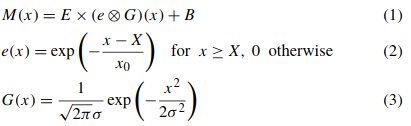

where
- *M* is the overall fit
- *E* is the emissions scaling factor in mol/s - **this is what we want!**
- *x* is the location of the measurement
- *X* is the virtual source location (may be up- or down-wind from the actual source)
- *x<sub>0</sub>* is the folding distance, which controls how quickly the plume decays
- *G* is a Gaussian smoothing function and *σ* is it's standard deviation

## So if we can measure this line density and fit the function, we get the emission rate!
Let's get to it.

I'll go 50 km up- and down-wind, and at each point get the line density for a swath 40 km wide.
Ideally I should convert to a projected [CRS](https://docs.qgis.org/3.4/en/docs/gentle_gis_introduction/coordinate_reference_systems.html) or use the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) but for now let's just rely on the fact that, near the equator 1 km ~= 0.01 degrees. This will make my life a bit easier, and I'm anyway only sampling at the resolution of the provided raster data, so won't be losing much (or any) accuracy.

From inspection of the wind rose from earlier, the median wind direction is directly westerly. Let's quickly check this:

In [ ]:
median_wind_direction = gfs_df.loc[gfs_df.mag > 3].compass.median()
print(f"Median wind direction: {median_wind_direction:.0f}°")

So this is actually slightly south of exactly west, but let's stick to a east-west cross-section for our analysis. I suspect if I took into account the higher impact of windier days (which may have a stronger than linear impact) I'd end up concluding the median wind *effect* is due west. Why? Because the NO<sub>2</sub> plume is going straight east! Note: I could also rotate the NO<sub>2</sub> fields on each day to line up with the wind direction for that day, but as the wind is already basically directly east-west, this probably isn't necessary. In a location with more varied wind directions, one could either calculate a separate profile for each direction, or do this NO<sub>2</sub> field rotation.

I want to quickly codify this in our list of power plants. However, to avoid double work, I'm going to take another step in simplifying our plants list by merging those that are right next to each other, as they'll be indistinguishable in terms of satellite imagery.

The table now has five entries, and those where multiple plants were close together have both names listed as well as both fuel types. I've also entered the primary wind direction for our first investigation.

In [ ]:
def merge_close_plants(plants, dist_deg=0.05):
    """
    Merge plants that are close together.
    Sum numerical values, list others.
    """
    
    buff = plants.copy()
    buff.geometry = buff.geometry.buffer(dist_deg)
    buff = gpd.GeoDataFrame(geometry=[p for p in buff.unary_union])
    buff["centroid"] = buff.geometry.centroid

    plants = gpd.sjoin(plants, buff, op="within")

    grouped = plants.groupby("index_right").sum()
    grouped["geometry"] = plants.groupby(["index_right"])["centroid"].first()
    grouped["primary_fuel"] = plants.groupby(["index_right"])["primary_fuel"].apply(lambda x: ", ".join(x))
    grouped["name"] = plants.reset_index().groupby(["index_right"])["index"].apply(lambda x: ", ".join(x))
    grouped = grouped.set_index("name")
    grouped["capacity_factor"] = grouped["generation_hourly"] / grouped["capacity_mw"]
    
    grouped = gpd.GeoDataFrame(grouped)
    grouped["xy"] = grouped.geometry.apply(lambda geom: [float(g[0]) for g in geom.coords.xy])
    
    return grouped

In [ ]:
plants = merge_close_plants(plants)
plants = pretty_cols(plants)
plants["wind_dir"] = ""
plants.at["San Juan CC, Palo Seco", "wind_dir"] = 90
plants[["Primary Fuel", "Capacity (MW)", "Hourly Generation (MWh)", "Capacity Factor", "wind_dir"]]

Now we're finally ready to start our in-depth investigation!

In [ ]:
def coords2pixel(aff, x, y):
    """
    Convert x, y in degrees to pixel coordinates in the array.
    Returned in row, col format as expected by numpy.
    Useful reference: https://www.perrygeo.com/python-affine-transforms.html
    """
    
    col, row = ~aff * (x, y)
    col, row = int(col), int(row)
    return row, col

In [ ]:
def get_line_density(arr, aff, x, y, length=100, width=20, angle=0):
    """
    Calculate line density plot for given image and x, y coordinates.
    Length and width are in km, angle is mathematical angle.
    (i.e. N=pi/2, E=0, S=-pi/2, W=pi=-pi)
    """
    
    arr_lines = np.zeros_like(arr)
    row1, col1 = coords2pixel(aff, x, y)
    samples = []
    up = int(length*1e3 / 2)
    for x_move in range(-up, up + 1, 100):
        line = []
        side = int(width*1e3 / 2)
        for y_move in range(-side, side + 1, 100):
            x_new = x + (x_move * cos(angle) - y_move * sin(angle)) * 1e-5
            y_new = y + (y_move * cos(angle) + x_move * sin(angle)) * 1e-5
            row, col = coords2pixel(aff, x_new, y_new)
            if row < 0 or col < 0:
                continue
            try:
                line.append(arr[row, col])
                arr_lines[row, col] = 1
                arr_lines[row, col] = 1
            except IndexError:
                pass
        if len(line) > 0:
            line_mean = np.mean(line) * width * 1e3  # to go from mol/m2 to mol/m
            samples.append({"x": x_move, "val": line_mean})
    line_df = pd.DataFrame(samples)
    line_df = line_df.set_index("x")
    return line_df, arr_lines

In [ ]:
x, y = plants.at["San Juan CC, Palo Seco", "xy"]
line_df, sample_loc = get_line_density(s5p_wind_mean, s5p_aff, x, y, length=160, width=40, angle=0)
xx = np.array(line_df.index.to_list())

The plot below shows the extents of sampling, up- and down-wind and to either side.

In [ ]:
def draw_sample_area(arr_no2, arr_sample):
    """Plot NO2 data with sample area overlaid."""
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(arr_no2, cmap="YlOrRd", vmin=0, vmax=2e-5)
    ax.imshow(arr_sample, cmap=ListedColormap([(0, 0, 0, 0), (0, 0, 0, .2)]))
    ax.grid(False)

    ax.set_title("NO2 with sample area", fontsize=16)
    sns.despine()
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.axis("off")
    plt.show()

In [ ]:
draw_sample_area(s5p_wind_mean, sample_loc)

## And this is what the profile looks like!

In [ ]:
def plot_density(measured, fit_xx=None, fit_yy=None, size=12):
    """Plot NO2 density versus profile position."""
    
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(size, size/2))
    x = measured.index
    spl = UnivariateSpline(x, measured.val)
    spl.set_smoothing_factor(0.005)
    ax.plot(x, spl(x), label="Measured", linewidth=4)
    ax.set_ylabel("NO2 line density (mol/m)", fontsize=16)
    ax.set_xlabel("x (km)", fontsize=16)
    ax.set_title("Line density profile (positive x is upwind)", fontsize=16)
    ax.set_xlim([-80e3 ,80e3])
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*1e-3))
    ax.xaxis.set_major_formatter(ticks)
    ax.set_ylim([0, 0.5])
    ax.arrow(20e3, 0.1, -40e3, 0, head_width=0.03, head_length=5e3, fc='k', ec='k')
    ax.text(-18e3, 0.12, "wind direction", fontsize=20)
    
    if fit_xx is not None:
        ax.plot(fit_xx, fit_yy, c="red", linewidth=4)
        ax.legend(["Measured", "Fit"])
        
    ax.xaxis.grid(False)
    ax.tick_params(axis='both', which='both', labelsize=12)
    sns.despine(left=True)
    plt.show()

In [ ]:
plot_density(line_df)

## So let's set up the model function
These are the functions *e*, *G* and *M* explained before.

In [ ]:
e = np.vectorize(lambda x, x0, X: np.exp((x+X)/x0) if x <= -X else 0)
G = lambda x, std: np.exp(-(x**2)/(2*(std**2)))/(np.sqrt(2*np.pi)*std)
M = lambda x, E, B, X, x0, std: E * np.convolve(e(x, x0, X), G(x, std), mode="same") + B

## Now we use a curve fit to find the parameters
This will give the values of *E*, *B*, *X*, *x<sub>0</sub>*, and *σ* that make the model best fit the data.

In [ ]:
def fit_model(M, xx, yy):
    p, cov = curve_fit(
        f=M,
        xdata=xx,
        ydata=yy,
        p0=(30, 0.25, 1e3, 5e4, 1e4),
        bounds=(
            (0, 0, -np.inf, -np.inf, -np.inf),
            (np.inf, np.inf, np.inf, np.inf, np.inf)
        ),
        method="trf",
    )
    return p

In [ ]:
E, B, X, x0, std = fit_model(M, xx, line_df.val.to_list())

In [ ]:
print(
    f"And these are our values!\nE:\t{E:.2f} mol/s"
    f"\nB:\t{B:.3f} mol/m"
    f"\nX:\t{X:.0f} m"
    f"\nx0:\t{x0:.0f} m"
    f"\nstd:\t{std:.0f}"
)

Let's plot this model fit against the measured data and see how it looks.

In [ ]:
yy = M(x=xx, E=E, B=B, X=X, x0=x0, std=std)
plot_density(line_df, xx, yy)

## It looks pretty good!
Now let's convert this *E* value to something more intelligible than mol/s and check some other things.

Firstly, the NO<sub>2</sub> decay time, *τ*, which is by dividing the *x<sub>0</sub>* distance by the mean wind speed.

In [ ]:
sec_per_hour = 3600
no2_mol_mass = 46e-3  # kg/mol

tau = (x0 / w_mean) / sec_per_hour  # to convert to hours
print(f"NO2 decay time: {tau:.2f} hours")

which agrees pretty well with the literature range of 3 - 8 hours.

Then we convert *E* in mol/s to output in kg/hr

In [ ]:
Ekghr = E * sec_per_hour * no2_mol_mass
print(f"NO2 output is {Ekghr:.0f} kg/hr")

The total hourly electricity generation of the San Juan area is 416 MWh/h. We can use this with the emissions above to calculate the emissions factor in kg/MWh!

In [ ]:
emission_fac = Ekghr / plants.loc["San Juan CC, Palo Seco", "generation_hourly"]
print(f"Naive emissions factor: {emission_fac:.2f} kg/MWh")

## Is that it!??
This is quite above the expected range of 2 - 3 kg/MWh, but I've forgotten one thing...

## Cars!!
If I can find a way to account for cars (and other sources of NO<sub>2</sub>), I should be able to calculate the real value! According to [this random source](http://www.apis.ac.uk/overview/pollutants/overview_nox.htm) from the UK, road traffic can account for more than 30% of emissions.

But how do we calculate which portion comes from cars and which from other sources?

# Modelling All the Emissions Sites
## The plan
I'll select a bunch of sites and then perform the curve-fitting procedure on each one. Except this time, I'll add an extra factor to account for other sources of emission. I'm also going to include a site with *no* power generation, so help solve for the unknown. I'll take total [night time lights](https://www.nasa.gov/topics/earth/earthday/gall_earth_night.html) emissions in a radius around each point and take that as an indicator of non-power-plant NO<sub>2</sub> emissions. Then I can disaggregate our *E* factor into two terms:

*E = E_elec + f_other x NTL*

where
- *E* is the total emissions
- *E_elec* is the emissions just from the power plants (what we're after!)
- *f_other* is some multiplier of emissions per light-output that we need to discover
- *NTL* is the known total light emissions for the area

## Let's choose our points and see what happens!
I selected the following points. These are the main fossil-fuel power plants, plus a large city near San Juan called Caguas. For this city, we know that *E_elec* will be exactly zero.
Using these locations, along with some knowledge of the fuels and generation activity of each plant, we have enough data points to solve the different unknown *E_elec* values along with the constant *f_other* factor that accounts for non-power NO<sub>2</sub> emissions.

I'm also going to exclude the Cambalache and Mayagüez plants: they are both very small producers (less than 1.5% of our selected sites) and the first is directly under San Juan's plume and won't be detectable, and the second is hovering on the edge of our satellite image, so we won't see its full plume. (It would be trivial to get more data to deal with this, but we're trying to keep things as simple as possible for now!)

So let's see the table with the latest chops and changes.

In [ ]:
plants = plants.loc[plants.generation_hourly > 100]
plants.loc["Caguas"] = {c: 0 for c in plants.columns}
plants.at["Caguas", "xy"] = [-66.04, 18.24]
plants.at["Caguas", "geometry"] = Point([-66.04, 18.24])
plants.at["Caguas", "Primary Fuel"] = plants.at["Caguas", "primary_fuel"] = "none"
plants.at["Caguas", "wind_dir"] = ""
plants[["Primary Fuel", "Capacity (MW)", "Hourly Generation (MWh)", "Capacity Factor", "wind_dir"]]

In [ ]:
print(f"Still our included plants account for {(100 * plants.capacity_mw.sum() / gppd.capacity_mw.sum()):.0f}% of the total system capacity.")

Great! So let's stick a 5 km buffer around each of our chosen sites and see what it looks like (in red below). Note also the new green marker at the town of Caguas.

In [ ]:
plants_buff = plants.copy()
plants_buff.geometry = plants_buff.geometry.buffer(0.05)

m = map_plants(plants)
folium.features.GeoJson(
    plants_buff.to_json(),
    style_function=lambda x: {
        "fillOpacity": 0.5,
        "weight": 0,
        "fillColor": "red",
    },
).add_to(m)
m

## Now we get the total night lights in each circle
First our night time lights. Seems to make sense - hot spots around San Juan and other towns.

In [ ]:
with rio.open(viirs_path) as rd:
    viirs = rd.read(1)
    viirs[np.isnan(viirs)] = 0
    viirs_aff = rd.transform
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(viirs, vmin=0, vmax=30)
plt.show()

Now we see the total light emitted for each area:

In [ ]:
ntl_sums = zonal_stats(
    plants_buff,
    viirs,
    affine=viirs_aff,
    stats=["sum"],
    nodata=-999,
)
plants["NTL"] = [int(n["sum"]) for n in ntl_sums]
plants[["NTL"]]

As expected, high NTL from San Juan and Caguas, but much less from the other plant sites that aren't in major towns.

## Now let's check the wind roses for each site

In [ ]:
for idx, row in plants.iterrows():
    print("Site:", idx)
    x, y = row["xy"]
    gfs_df = get_wind_data_point(gfs_path, x=x, y=y, disable_tqdm=True)
    rose = make_rose(gfs_df)
    fig, ax = draw_rose(rose, size=5)
    plt.show()

They're all pretty similar, and all just about majority easterly wind, although the sites on the south coast do have a bit of a northerly component, and a bit weaker pverall. for simplicity let's just do all our wind profiles east-west. And let's set this decision into our table (remember 90° is east!).

In [ ]:
plants["wind_dir"] = 90
plants[["wind_dir"]]

## Now the curve fit procedure for each site
Which gives the emissions (*E*) for each site in kg/hr.

In [ ]:
def get_E_value(x, y, sample_length=160):
    gfs_df = get_wind_data_point(gfs_path, x=x, y=y, disable_tqdm=True)
    
    s5p_arrs, aff = s5p_arr_timeseries(s5p_path, gfs_df, disable_tqdm=True)
    wind_cutoff = 2.5
    s5p_wind = [w["arr"] for w in s5p_arrs if w["wind"] >= wind_cutoff]
    s5p_wind_mean = np.nanmean(np.stack(s5p_wind), axis=0)
    
    line_df, sample_loc = get_line_density(s5p_wind_mean, s5p_aff, x, y, length=sample_length, width=40)
    xx = np.array(line_df.index.to_list())
    E, B, X, x0, std = fit_model(M, xx, line_df.val.to_list())
    yy = M(x=xx, E=E, B=B, X=X, x0=x0, std=std)
    plot_density(line_df, xx, yy, size=6)
    
    return E

In [ ]:
plants["E_kghr"] = 0
for idx, row in plants.iterrows():
    print("Site:", idx)
    x, y = row["xy"]
    E = get_E_value(x, y)
    plants.at[idx, "E_kghr"] = E * sec_per_hour * no2_mol_mass

Clearly there is something wrong with the Costa Sur/EcoElectrica site! The line density profile makes no sense and there's no clear jump in NO2 behind the power plants. Either it is emitting very little NO2, or it just isn't showing up for some reason. Unfortunately I'll have to exclude it from our analysis for now.

Let's have a look at the values for E in kg/hr for the remaining sites (remember this is the *total* E at each point, for electricity and other sources):

In [ ]:
plants = plants.drop(["Costa Sur, EcoEléctrica"])
plants[["E_kghr"]]

## Now we can solve for the unknown values
We have

*E = E_elec + f_other x NTL*

for each of the points. And we know Caguas has *E_elec = 0* which let's us solve for *f_other*:

*f_other = (E - E_elec)/NTL = E/NTL*

In [ ]:
f_other = float(plants.at["Caguas", "E_kghr"] / plants.at["Caguas", "NTL"])
print(f"f_other = {f_other:.4f}")

Now we can use *f_other* and *NTL* to calculate *Eelec* for each of the other stations

In [ ]:
plants["E_elec_kghr"] = (plants["E_kghr"] - f_other * plants["NTL"]).astype(int)
plants[["Capacity (MW)", "Hourly Generation (MWh)", "NTL", "E_kghr", "E_elec_kghr"]]

And then we just use the estimated generation for each plant to calculate its emissions factor and then we can get a weighted emissions factor!

In [ ]:
plants["EF"] = round(plants["E_elec_kghr"] / plants["generation_hourly"], 2)
plants.at["Caguas", "EF"] = 0
plants[["Primary Fuel", "Capacity (MW)", "Hourly Generation (MWh)", "EF"]]

In [ ]:
EF_mean = np.average(plants["EF"], weights=plants["generation_hourly"])
print(f"Weighted average EF is {EF_mean:.2f} kg/MWh")

## Is that it?? Are we done yet?
Just about. We must bring back in the excluded power plants, some of which have emissions that we couldn't measure, and others which have no emissions.

In [ ]:
eia = pd.read_csv(eia_path)
eia["generation_hourly"] = eia["Netgen_Total"] / (265 * 24)
total_gen = eia.generation_hourly.sum()
fossil_codes = ["NG", "BIT", "DFO", "RFO"]
total_fossil_gen = eia.loc[eia.Fuel_Code.isin(fossil_codes)].generation_hourly.sum()
captured_gen = plants.generation_hourly.sum()

In [ ]:
print(f"Total average hourly generation for Puerto Rico:\t{total_gen:.0f} MWh")
print(f"Of which, the amount that is polluting:\t\t\t{total_fossil_gen:.0f} MWh\t({(100*total_fossil_gen/total_gen):.0f}% of total)")
print(f"Of which, the amount included in the analysis:\t\t{captured_gen:.0f} MWh\t\t({(100*captured_gen/total_gen):.0f}% of total)")

There's no single way to deal with this, but we can do our best. We can either:
1. Assume our EF above applies to all energy produced on the island;
2. Assume the rest have no emissions;
3. Assume they follow general trends of pollution for their fuel type (coal, oil, or gas).

Number 1 is the number we already calculated, which is probably an overestimate, while number 2 will be significantly lower and is probably an under-estimate. Let's quickly try method 3 and see what it gives us.

All the emissions from the two San Juan plants are oil. Therefore we can take that site's EF as the Puerto Rico EF for oil. The other site we measured was a mix of coal and oil. Using the oil EF we calculate, we can use the weighted generation (by oil and by coal) to calculate the EF for coal. We have no information about gas... But luckily it doesn't account for much of Puerto Rico's generation. Going by our generic EF values from way up top, let's say it's five times lower than EF for oil. Thus we have for all three:

In [ ]:
EF_oil = plants.at["San Juan CC, Palo Seco", "EF"]
print(f"EF for oil: {EF_oil:.2f} kg/MWh")

gen_coal = int(eia.loc[eia.Plant_Name == "AES Puerto Rico", "generation_hourly"])
gen_oil = int(eia.groupby("Plant_Name").sum().at["Aguirre Plant", "generation_hourly"])
EF_coal = (((plants.at["A.E.S. Corp., Aguirre", "EF"]) * (gen_coal + gen_oil)) - (gen_oil * EF_oil))/gen_coal
print(f"EF for coal: {EF_coal:.2f} kg/MWh")

EF_gas = EF_oil / 5
print(f"EF for gas: {EF_gas:.2f} kg/MWh")

Now we're ready to extrapolate our total emissions.

In [ ]:
def calc_emissions(row):
    if row.Fuel_Code in ["NG"]:
        return EF_gas * row["generation_hourly"]
    elif row.Fuel_Code in ["BIT"]:
        return EF_coal * row["generation_hourly"]
    elif row.Fuel_Code in ["DFO", "RFO"]:
        return EF_oil * row["generation_hourly"]
    else:
        return 0
eia["emissions_kghr"] = eia.apply(calc_emissions, axis="columns")

In [ ]:
EF_method3 = eia.emissions_kghr.sum() / eia.generation_hourly.sum()
print(f"EF if we extrapolate to other plants: {EF_method3:.2f} kg/MWh")
print("This is probably the best estimate!")

## So there we have it, final answer!
Or a bit lower if we assume the other plants don't pollute, or a bit higher if we assume uniform emissions.

# Bonus Points
## We can now calculate the marginal emissions factor
For a marginal emissions factor to be meaningful, we'd need a lot more generation data, down to daily or better resolution. This would enable an understanding of, at each point in time, what the environmental impact of a decision to use electricity would be. Even an average factor would need to take into account which plants are historically at the margin of additional power demand. Since we don't have that, let's just assume that marginal power comes from fossil fuel plants. There are quite a few ways we could go about this in the absence of data...

Let's say that coal is unlikely to be on the margin (oil and gas are hapipier being ramped up and down), so our marginal power will come from either gas or oil. Then we can calculate aan average (weighted by generation) of the emission factors of each of these fuels.

In [ ]:
gen_gas = eia.loc[eia.Fuel_Code == "NG"].Netgen_Total.sum()
gen_oil = eia.loc[eia.Fuel_Code.isin(["RFO", "DFO"])].Netgen_Total.sum()
EF_marginal = (EF_gas * gen_gas + EF_oil * gen_oil)/(gen_gas + gen_oil)
print(f"Marginal EF: {EF_marginal:.2f} kg/MWh")

## A bit lower, but just because we left out coal
This really requires a bit more knowledge about Puerto Rico's daily generation and price-demand curves!

## What about calculating the EF on a monthly basis?
In theory easy (just apply the method to only a month of data at a time), but as there's only one NO2 image per day, we start to stretch it a bit thin. Will do it and we can see what the results look like and if they correlate with anything. No expectation that they will change dramatically, as renewable (wind, solar, hydro) penetration isn't high enough (~6%) to drastically change the proportion of electricity coming from fossil (polluting) sources.

Let's see how we would do this just for San Juan. First we create a new dict with separate NO2 and wind data for each month.

In [ ]:
def calc_monthly(x, y):
    gfs_df = get_wind_data_point(gfs_path, x=x, y=y, disable_tqdm=True)
    s5p_arrs, aff = s5p_arr_timeseries(s5p_path, gfs_df, disable_tqdm=True)
    
    s5p_arrs = sorted(s5p_arrs, key=lambda x: x["date"])
    s5p_monthly = {}
    for d in s5p_arrs:
        year = d["date"].year
        month = d["date"].month
        ym =  f"{year}-{month:02}"
        if ym not in s5p_monthly.keys():
            s5p_monthly[ym] = []
        s5p_monthly[ym].append(d)
    
    results = {}
    for month, vals in s5p_monthly.items():
        wind_cutoff = 2.5
        s5p_wind = [w["arr"] for w in vals if w["wind"] >= wind_cutoff]
        s5p_wind_mean = np.nanmean(np.stack(s5p_wind), axis=0)
        line_df, sample_loc = get_line_density(s5p_wind_mean, aff, x, y, length=160, width=40)
        xx = np.array(line_df.index.to_list())
        try:
            E, B, X, x0, std = fit_model(M, xx, line_df.val.to_list())
        except RuntimeError:
            E = np.nan
        results[month] = int(E * sec_per_hour * no2_mol_mass)
    return results

In [ ]:
x, y = plants.at["San Juan CC, Palo Seco", "xy"]
E_monthly = calc_monthly(x, y)
print("Monthly emissions for San Juan area (from all sources!)")
monthly = pd.DataFrame(E_monthly.values(), index=E_monthly.keys(), columns=["E_kghr"])
monthly.index = pd.to_datetime(monthly.index)
monthly.head()

At this point we could repeat the above procedure, using NTL each month (NTL data is available as monthly composites!) to disaggregate power and non-power emissions, and using the monthly generation from each plant to determine a monthly EF factor. However, I think this is sufficient as a demonstration of the potential of this method, Anyway I think we might start stretching our assumptions a bit thin to keep going without stopping for a validity check on how we've done so far!

To get a quick answer out of this, let's just divide the emissions each month by Puerto Rico's total generation for that month (remembering that the generation is from 2018, whereas our NO2 data is from 2018-2019, but we assume each month has similar characteristics regardless of year). Then we'll just normalise the results to have a mean equal to the annual EF we already calculated!

In [ ]:
monthly["EF_high"] = np.nan
for idx, row in monthly.iterrows():
    month = idx.strftime("%B")
    monthly.at[idx, "EF_high"] = round(row["E_kghr"] / (eia[f"Netgen_{month}"].sum() / (24 * 365)), 2)
monthly["EF"] = (monthly["EF_high"] * EF_method3 / monthly["EF_high"].mean()).round(2)

And this is what it looks like!

In [ ]:
def plot_monthly_EF(df):
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(16,6))
    df[["EF"]].plot(ax=ax, linewidth=4)
    ax.set_ylim([0, 3])
    ax.set_title("Emissions Factor (EF) by date", fontsize=16)
    ax.set_ylabel("EF (kg/MWh)", fontsize=16)
    ax.set_xlabel("Date", fontsize=16)
    ax.tick_params(axis='both', which='both', labelsize=12)
    
    ax.xaxis.grid(False)
    ax.legend()
    sns.despine(left=True)
    plt.show()

In [ ]:
plot_monthly_EF(monthly)

## And now we're seriously done!

# Caveats and Recommendations
As mentioned, I decided to keep it as simple as possible for this demonstration. There is also quite a long chain of assumptions that could build up to several inaccuracies.

The most obvious improvement would be to include a larger patch of wind and NO<sub>2</sub> data, extending much further to each side of Puerto Rico (especially downwind!). This should give much more freedom in creating our wind profiles. As mentioned, we should also use atmospheric data that matches month for month with our generation data, but this isn't always possible if we want the latest numbers! (I haven't managed to find 2019 generation numbers for Puerto Rico, but they probably exist at the end of the right email address).

One big assumption was assuming non-power pollution scales linearly with night time lights (NTL). We should also investigate other data sources such as population distribution, road networks etc, and explore the possibility of a nonlinear relationship (e.g. more night time lights in one area indicates more intensive industry, which could create a much more than linear increase in NO<sub>2</sub> emissions). Our choice of NTL sampling area (circle with 5 km radius) was also essentially random and needs to be investigated.

We were lucky that Puerto Rico's wind is so well behaved. A more general analysis would require rotating the NO<sub>2</sub> fields (as has been done in the literature) or separatingly sampling along major wind directions (which I wrote the code for above but didn't use). The line density profile also assumes a near point source of emissions, but we know that isn't the case. We might need to investigate including multiple model functions to fit one density line, each representing a different emission source (this might allow us to model the plants further west under San Juan's plume).

We should also look into additional effects on NO<sub>2</sub>, such as temperature, humidity, precipitation etc (in this analysis I haven't even touched the [GLDAS](https://developers.google.com/earth-engine/datasets/catalog/NASA_GLDAS_V021_NOAH_G025_T3H) dataset). However, without decent training data it will be difficult to include these other data sources that aren't as easy to analyse with a simple, logical approach.

To apply this method in other areas, there are a few things which would need to be considered (in addition to those mentioned above). The assumption about no wind blowing in would generally not be true, though this shouldn't affect the line density procedure much unless the plumes are very close. For areas with more variable wind, the analysis would either have to be done separately for different wind directions, or the NO<sub>2</sub> fields rotated according to each day's wind. The process of disaggregating power and non-power pollution would need to be assessed, and in dense areas it is likely that many plants would be under the plumes of others, in which case the suggestion above of multiple model functions should be explored.